#### 3 indicator dataset
 
Two-armed bandit foraging task, imaging with 3 indicators
 
1. Calcium - TGECO (based on mTFP spectrum)
2. Acetylcholine - iAChSnFR (based on mVenus spectrum)
3. Dopamine - GRAB-rDA3m (based on mApple spectrum)

- There are two fibers implanted in the brain.
- Wavelengths are calibrated to pixel position.
- The data is seperated by laser being triggered.

Keys:

 - `L_405_F1`  : contains 2d arrays with (laser) `L_405` and fiber `F1`.
 - `time_405`  : timestamps for `L_405_F1` rows.
 - `wavelength`: wavelength (nm) for `L_405_F1` columns.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import xarray as xr
from rich import print as pprint
import h5py
import pandas as pd
from tqdm import tqdm
from sourcesep.utils.config import load_config

xr.set_options(display_style="html", display_expand_data=False)
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", font_scale=0.8, rc=custom_params)
%config InlineBackend.figure_format="retina"

paths = load_config(dataset_key="all")

Paths are for dataset tagged: all


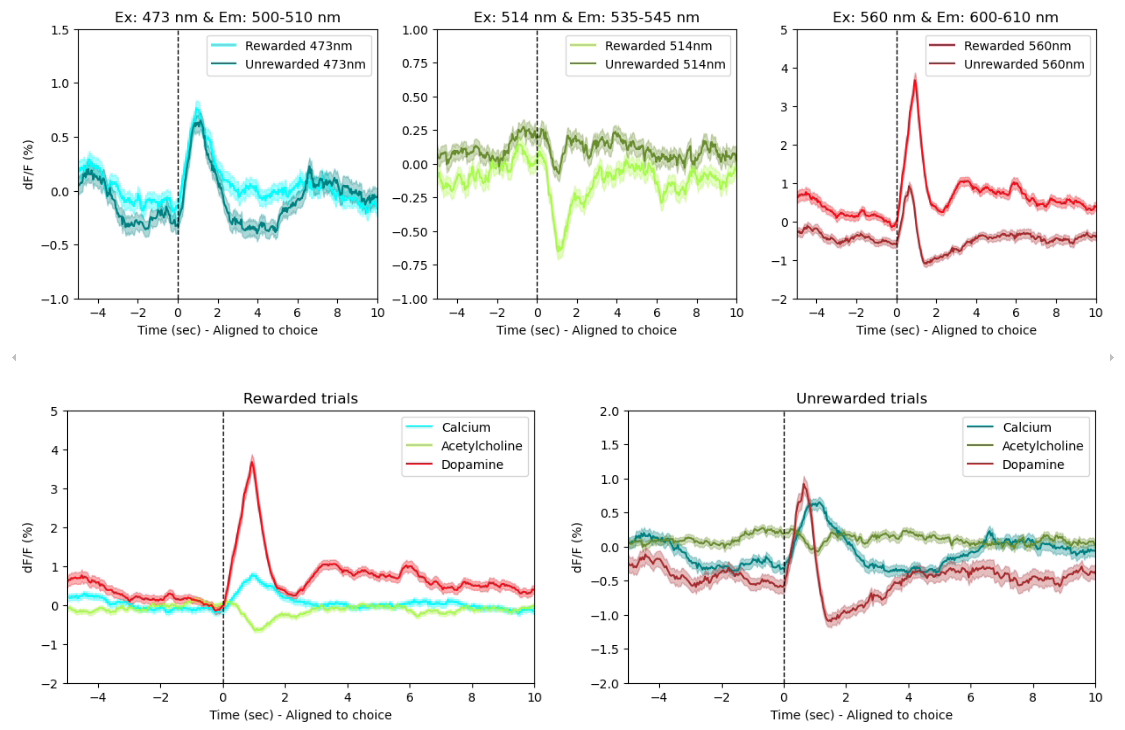

In [2]:
from IPython.display import Image

# These corerspond to measurements in Fiber 2
# time = 0 was manually shifted here.
Image(filename=str(paths["3indicator"]) + "/trialAveragedPlots.PNG")

In [3]:
df_licks = pd.read_csv(str(paths["3indicator"]) + "/lick_times_reward_status.csv")
t_licks = df_licks["timestamp"].values
reward = df_licks["reward"].values
print(f"There are {t_licks.size} distinct trials")

display(df_licks["reward"].value_counts().to_frame())

There are 602 distinct trials


count
reward       
0         338
1         264

In [4]:
# Load HSFP preprocessed hdf5 file

f = h5py.File(str(paths["3indicator"]) + "/hsfp_data_preprocessed.hdf5", "r")
# Show all the variables in the hdf5 file
for key in f.keys():
    print(key)

time_405 = np.array(f["Time_405"])
time_445 = np.array(f["Time_445"])
time_473 = np.array(f["Time_473"])
time_514 = np.array(f["Time_514"])
time_560 = np.array(f["Time_560"])
timestamps = np.array(f["Full_TimeStamps"])
lasers = np.array(f["Lasers"])
wavelength = np.array(f["Wavelength"])
L_405_F1 = np.array(f["Channel_405_F1"])
L_405_F2 = np.array(f["Channel_405_F2"])
L_445_F1 = np.array(f["Channel_445_F1"])
L_445_F2 = np.array(f["Channel_445_F2"])
L_473_F1 = np.array(f["Channel_473_F1"])
L_473_F2 = np.array(f["Channel_473_F2"])
L_514_F1 = np.array(f["Channel_514_F1"])
L_514_F2 = np.array(f["Channel_514_F2"])
L_560_F1 = np.array(f["Channel_560_F1"])
L_560_F2 = np.array(f["Channel_560_F2"])

Channel_405_F1
Channel_405_F2
Channel_445_F1
Channel_445_F2
Channel_473_F1
Channel_473_F2
Channel_514_F1
Channel_514_F2
Channel_560_F1
Channel_560_F2
Full_TimeStamps
Lasers
Time_405
Time_445
Time_473
Time_514
Time_560
Wavelength


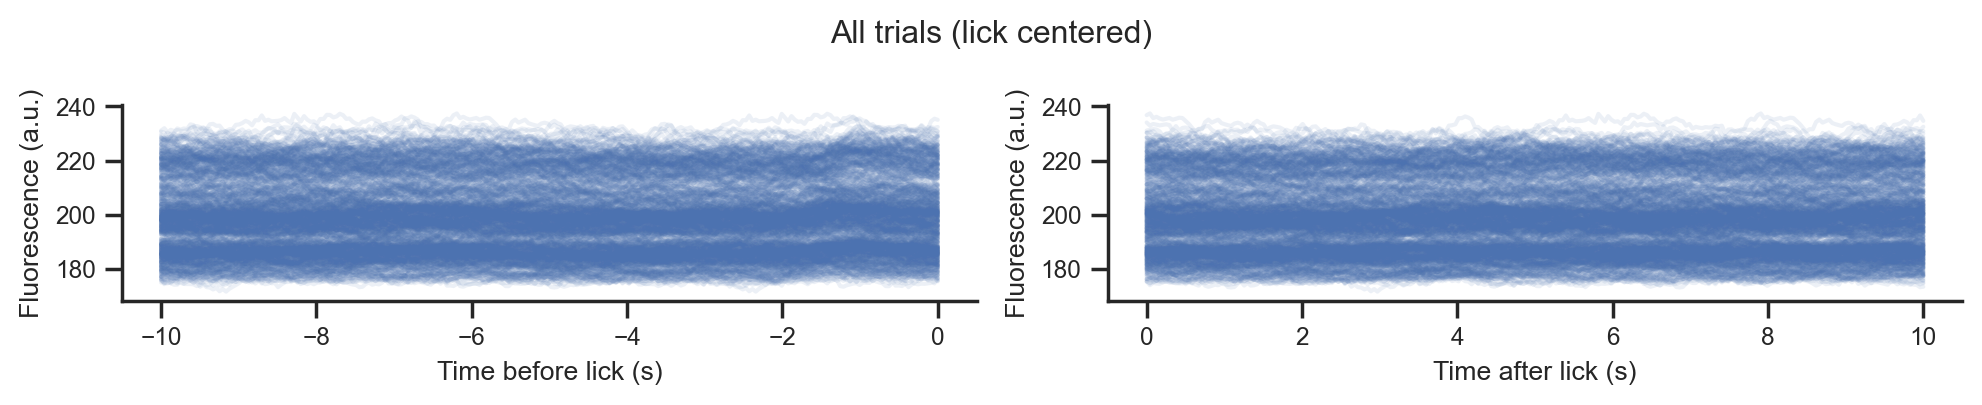

In [5]:
t_interval = 10  # in seconds
f_sampling = 24  # in Hz


def get_interval_ind(t_lick, time_series):
    ind_lick = np.argmin(np.abs(t_lick - time_series))
    inds_after = np.arange(ind_lick, ind_lick + (f_sampling * t_interval))
    inds_after = inds_after[inds_after < np.size(time_series)]
    inds_before = np.arange(ind_lick - (f_sampling * t_interval), ind_lick)
    inds_before = inds_before[inds_before >= 0]
    return inds_before.astype(int), inds_after.astype(int)


def get_wavelength_ind(this_wavelength, wavelengths):
    ind = np.argmin(np.abs(this_wavelength - wavelengths))
    return ind


def avg_over_wavelengths(F):
    # assumes F has dimensions (time, wavelengths)
    return np.mean(F, axis=1)


n_trials = t_licks.size
X_trials_before = np.zeros((t_interval * f_sampling, n_trials))
X_trials_after = np.zeros((t_interval * f_sampling, n_trials))


F_source = L_473_F2
wavelength_min = 500
wavelength_max = 510

f, ax = plt.subplots(1, 2, figsize=(10, 2))
for i, t_lick in enumerate(t_licks):
    inds_before, inds_after = get_interval_ind(t_lick, time_405)
    ind_wavelengths = np.arange(
        get_wavelength_ind(wavelength_min, wavelength),
        get_wavelength_ind(wavelength_max, wavelength),
    )
    time_before_lick = time_405[inds_before] - time_405[inds_before[-1]]
    time_after_lick = time_405[inds_after] - time_405[inds_after[0]]

    F_before = avg_over_wavelengths(F_source[np.ix_(inds_before, ind_wavelengths)]).flatten()
    F_after = avg_over_wavelengths(F_source[np.ix_(inds_after, ind_wavelengths)]).flatten()

    X_trials_before[-F_before.size :, i] = F_before
    X_trials_after[: F_after.size :, i] = F_after

    our_time = np.linspace(
        0, t_interval, F_before.size
    )  # fix for 30s jumps in time that occur on 9 different occasions.
    ax[0].plot(our_time - t_interval, F_before, "b", alpha=0.1)
    ax[0].set(xlabel="Time before lick (s)", ylabel="Fluorescence (a.u.)")
    ax[1].plot(our_time, F_after, "b", alpha=0.1)
    ax[1].set(xlabel="Time after lick (s)", ylabel="Fluorescence (a.u.)")

f.suptitle("All trials (lick centered)")
plt.tight_layout()
plt.show()

[Text(0.5, 0, 'Time (s)'),
 Text(0, 0.5, 'Fluorescence (a.u.)'),
 Text(0.5, 1.0, 'Average fluorescence over all trials'),
 (0.0, 250.0),
 (0.0, 600.0)]

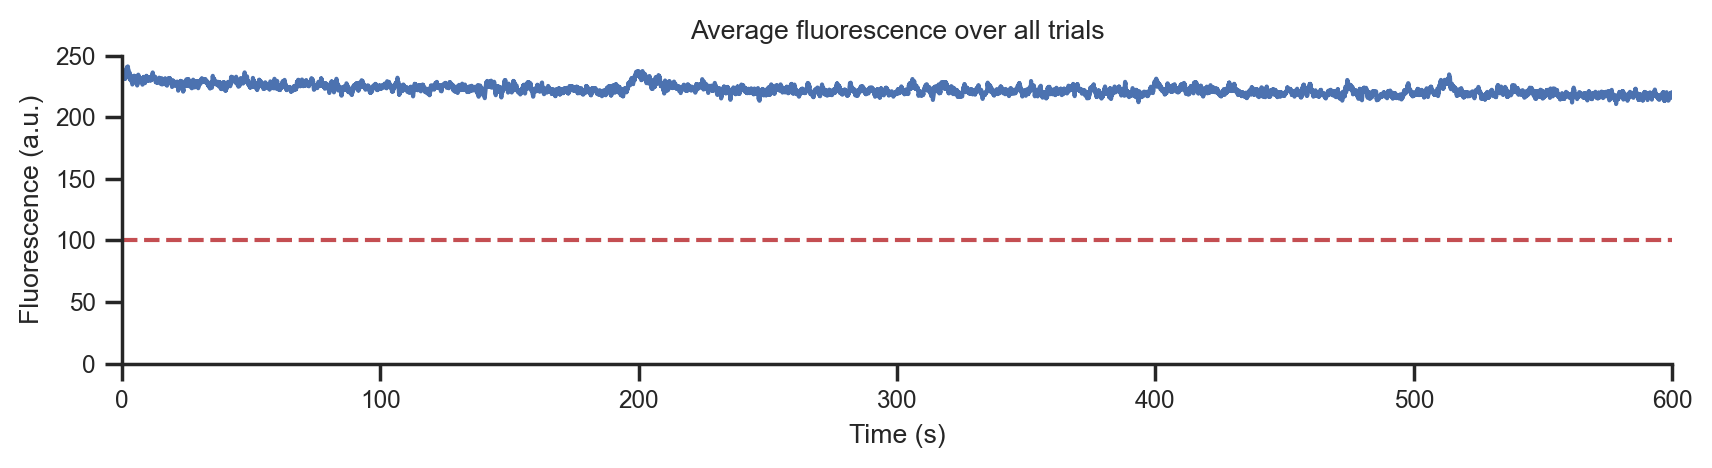

In [6]:
F_source_avg = avg_over_wavelengths(F_source[np.ix_(np.arange(F_source.shape[0]), ind_wavelengths)])
f, ax = plt.subplots(1, 1, figsize=(10, 2))
ax.plot(time_405 - time_405[0], F_source_avg)
ax.axhline(100, color="r", linestyle="--", label="approx. camera offset")
ax.set(
    xlabel="Time (s)",
    ylabel="Fluorescence (a.u.)",
    title="Average fluorescence over all trials",
    ylim=[0, 250],
    xlim=[0, 600],
)

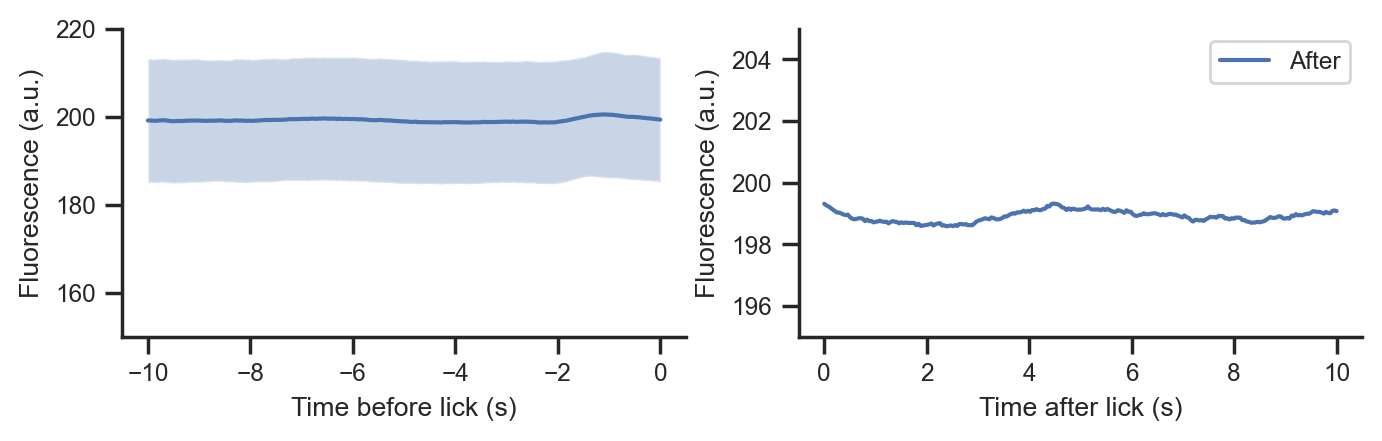

In [7]:
# trial-averaged plot (rewarded and unrewarded trials are not separated.)
X_trials_before_mean = np.mean(X_trials_before, axis=1)
X_trials_before_std = np.std(X_trials_before, axis=1)


f, ax = plt.subplots(1, 2, figsize=(8, 2))
ax[0].plot(our_time - t_interval, X_trials_before_mean, label="Before")
# plot std around the mean
ax[0].fill_between(
    our_time - t_interval,
    X_trials_before_mean - X_trials_before_std,
    X_trials_before_mean + X_trials_before_std,
    alpha=0.3,
)
ax[0].set(xlabel="Time before lick (s)", ylabel="Fluorescence (a.u.)", ylim=[150, 220])
ax[1].plot(our_time, np.mean(X_trials_after, axis=1), label="After")
ax[1].set(xlabel="Time after lick (s)", ylabel="Fluorescence (a.u.)", ylim=[195, 205])

plt.legend()
plt.show()

[Text(0.5, 0, 'Time (s)'),
 Text(0, 0.5, 'Fluorescence (a.u.)'),
 Text(0.5, 1.0, 'Detrended signal'),
 (0.0, 250.0),
 (0.0, 4000.0)]

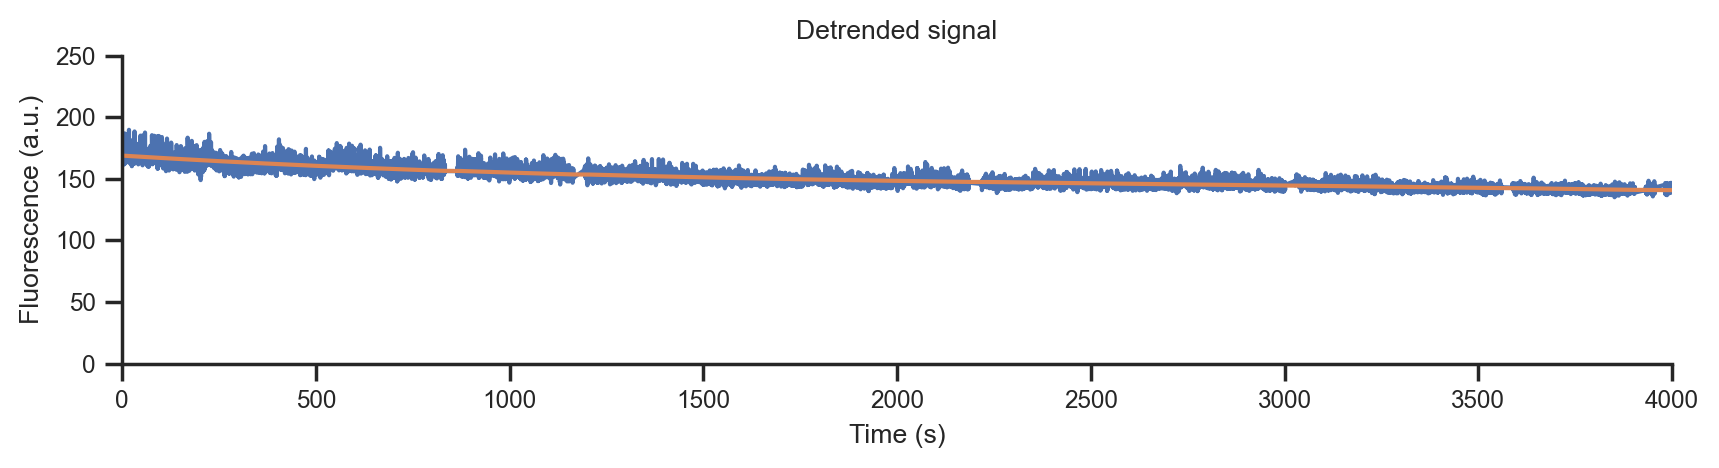

In [8]:
def detrend_signal(signal):
    x = np.arange(len(signal))
    p = np.polyfit(x, signal, 4)
    y = np.polyval(p, x)
    signal_detrended = signal - y + np.mean(signal)
    return signal_detrended, y


px = 605
detrended_signal, y_fit = detrend_signal(L_560_F2[:, px - 400])

f, ax = plt.subplots(1, 1, figsize=(10, 2))

ax.plot(time_560 - time_560[0], L_560_F2[:, px - 400])
# ax.plot(time_560 - time_560[0], detrended_signal)
ax.plot(time_560 - time_560[0], y_fit)
ax.set(
    xlabel="Time (s)",
    ylabel="Fluorescence (a.u.)",
    title="Detrended signal",
    ylim=[0, 250],
    xlim=[0, 4000],
)

In [9]:
# there are some dropped frames
t = time_445 - time_445[0]
dt = np.diff(t)
ind = np.where(dt > 1)[0]
display(pd.DataFrame({"t-t0 (s)": t[ind], "dt (s)": dt[ind]}))

t-t0 (s)     dt (s)
0   833.325070  31.973589
1  1165.268972  28.782836
2  2185.716117  32.379146
3  3001.418173  25.720364
4  3560.451301  27.461707
5  3904.550460  27.560833
6  3957.070611  24.372810
7  4139.741299  20.290160
8  4343.330312  21.457880

In [10]:
# we'll round this up to 24 Hz
print(f"sampling freq (Hz) {1/np.median(np.diff(time_405 - time_405[0])):0.4f}")

sampling freq (Hz) 23.9998


In [11]:
# there are 105400 samples
print(L_405_F1.shape)
print(np.unique(np.diff(wavelength)) == 1)
n_samples = L_405_F1.shape[0]
n_wavelengths = L_405_F1.shape[1]

(105400, 300)
[ True]


In [12]:
from sourcesep.data import Data
from sourcesep.utils.config import load_config

paths = load_config(dataset_key="all")
dat = Data(n_samples=None, cfg_path=paths["root"] / "3-indicator_data_config.toml")


def tri_indicator_plots(mean_X, dat, laser):
    N = dat.get_notches()
    n_lasers = dat.W.shape[1]
    f, ax = plt.subplots(1, n_lasers, figsize=(12, 2))
    for j in range(n_lasers):
        for i in range(dat.S.shape[0]):
            ax[j].plot(dat.L_arr, dat.S[i, :] * dat.W[i, j], label=dat.get_S_names()[i])
        ax[j].set(xlabel="Wavelength (nm)", ylabel="Intensity", title=f"{laser[j]}", ylim=(-0.02, 1), xlim=(400, 700))
        ax[j].plot(dat.L_arr, N, c="gray", alpha=0.5, ls="-", label="notches")
    plt.legend()
    plt.tight_layout()

    f, ax = plt.subplots(1, n_lasers, figsize=(12, 2))
    for j in range(n_lasers):
        ax[j].plot(dat.L_arr, mean_X[j, :], c="k", alpha=0.5, label="mean")
        ax[j].plot(dat.L_arr, N * 3, c="gray", ls="-", alpha=0.5, label="notches")

        ax[j].axhline(1.5, c="r", ls="--")
        ax[j].set(
            xlabel="Wavelength (nm)",
            ylabel="Median-normalized",
            title=f"{laser[j]}, median={np.median(mean_X[j,:]):0.2f}",
            ylim=(-0.02, 3),
            xlim=(400, 700),
        )

    plt.tight_layout()
    plt.show()
    return

Paths are for dataset tagged: all
Paths are for dataset tagged: all


In [13]:
S = dat.get_S()
print(dat.get_S_names())

W = dat.get_W()
display(dat.W_df)

['mTFP' 'mVenus' 'mApple']


405     445     473     514     560
mTFP    0.2480  0.8576  0.7098  0.0014  0.0002
mVenus  0.0108  0.0413  0.1939  0.9907  0.0013
mApple  0.0069  0.0294  0.0920  0.3863  0.8797

In [14]:
X = np.stack([L_405_F2, L_445_F2, L_473_F2, L_514_F2, L_560_F2])
print(X.shape)

X = np.swapaxes(X, 0, 1)
print(X.shape)

time_from_start = time_405 - time_405[0]
F = xr.DataArray(
    X,
    dims=("time", "laser", "wavelength"),
    coords={"time": time_from_start, "laser": [405, 445, 473, 514, 560], "wavelength": wavelength},
)

(5, 105400, 300)
(105400, 5, 300)


In [15]:
print(np.all(dat.L_arr == wavelength))
print(dat.S.shape)

True
(3, 300)


In [16]:
from sourcesep.utils.compute import detrend_signal

F_detrend = detrend_signal(F)

100%|██████████| 5/5 [00:34<00:00,  6.82s/it]


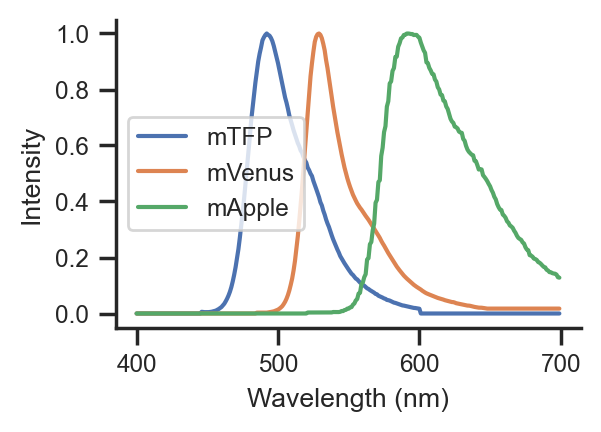

In [17]:
f, ax = plt.subplots(1, 1, figsize=(3, 2))
for i in range(dat.S.shape[0]):
    ax.plot(dat.L_arr, dat.S[i, :], label=dat.get_S_names()[i])
ax.set(xlabel="Wavelength (nm)", ylabel="Intensity")
plt.legend()
plt.show()

In [18]:
pprint(dat.cfg["laser"])
laser = [405, 445, 473, 514, 560]

{
    'l0': {'em_wavelength_nm': 405},
    'l1': {'em_wavelength_nm': 445},
    'l2': {'em_wavelength_nm': 473},
    'l3': {'em_wavelength_nm': 514},
    'l4': {'em_wavelength_nm': 560}
}

In [19]:
mean_X = F_detrend.mean("time")
print(f"{np.median(mean_X.values):0.3f}")

126.832


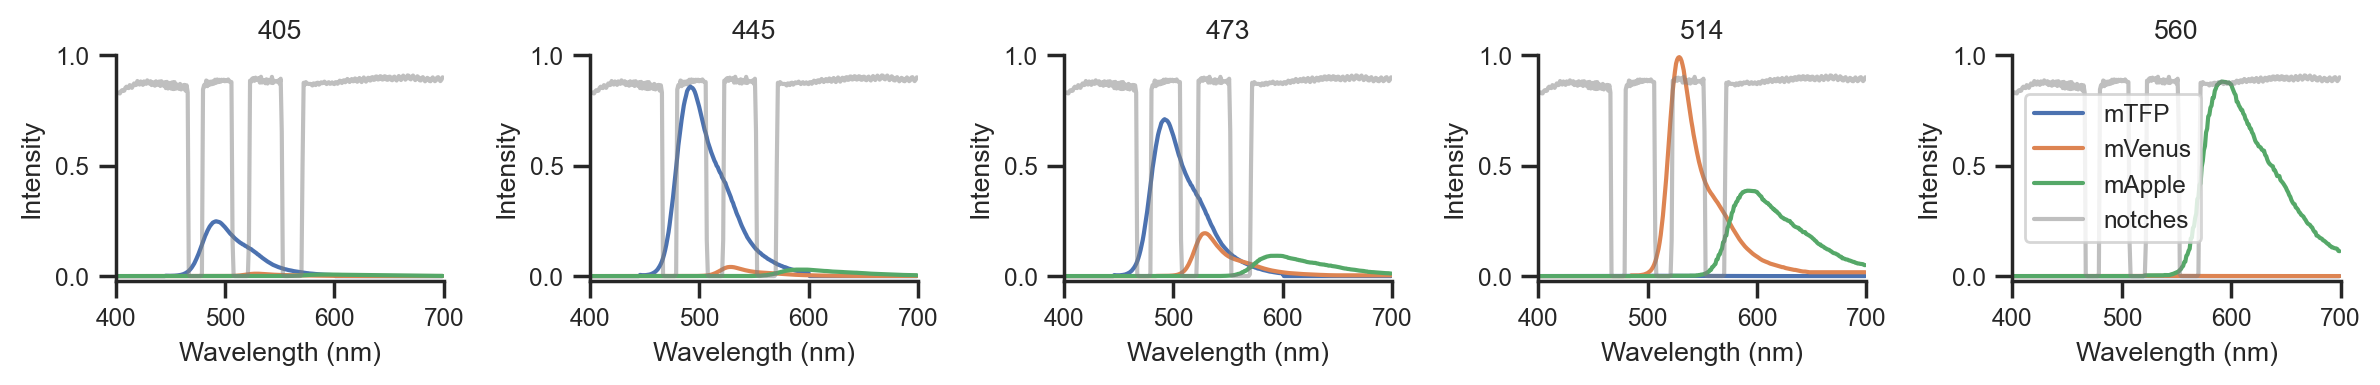

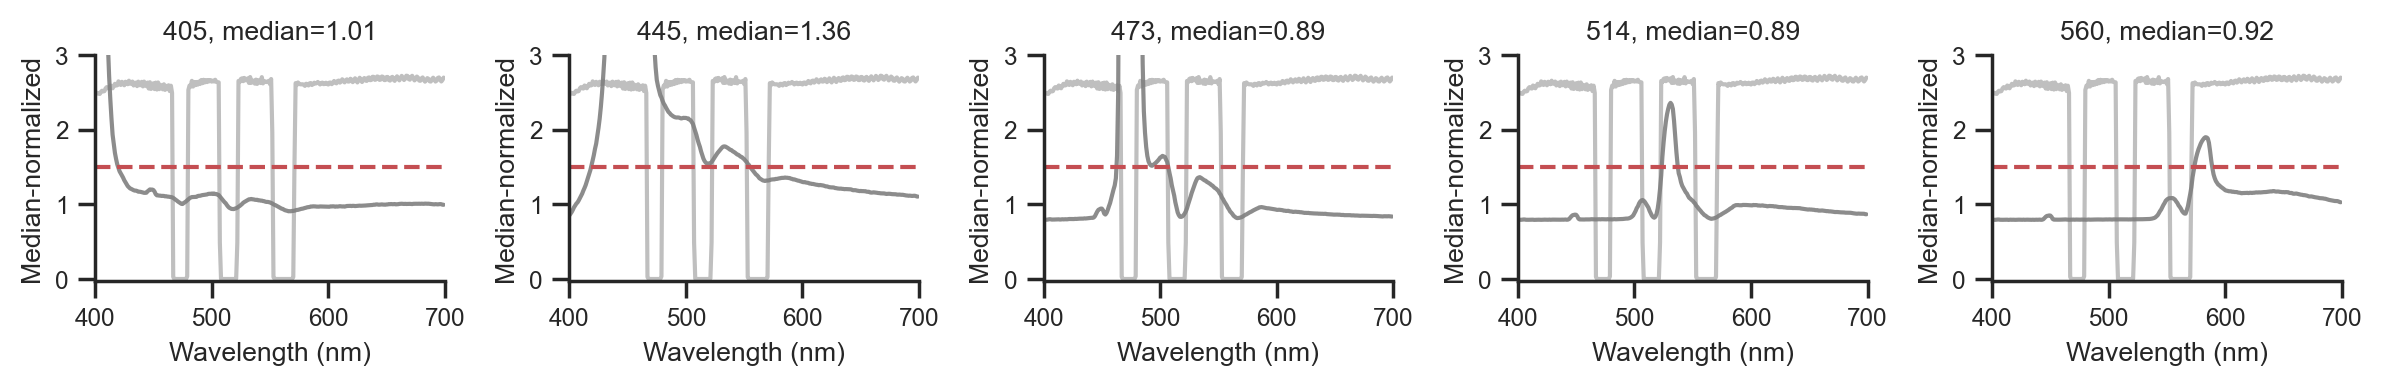

In [20]:
mean_X = F_detrend.mean("time")
normalizing_factor = np.median(mean_X.values)
mean_X = mean_X / normalizing_factor
tri_indicator_plots(mean_X, dat, laser)

In [21]:
# anything greater than 2.5 x the median is dominated by laser noise.
# normalize these particular values to 2.5 (or even lower!).
F_detrend_normalized = F_detrend / normalizing_factor

threshold = 2.5
F_detrend_normalized.mean("time") > threshold
for i in tqdm(range(F_detrend_normalized.shape[1])):
    for j in range(F_detrend_normalized.shape[2]):
        mean_val = F_detrend_normalized[:, i, j].mean()
        if mean_val > threshold:
            F_detrend_normalized[:, i, j] = (threshold / 2) * F_detrend_normalized[:, i, j] / mean_val

100%|██████████| 5/5 [00:02<00:00,  1.84it/s]


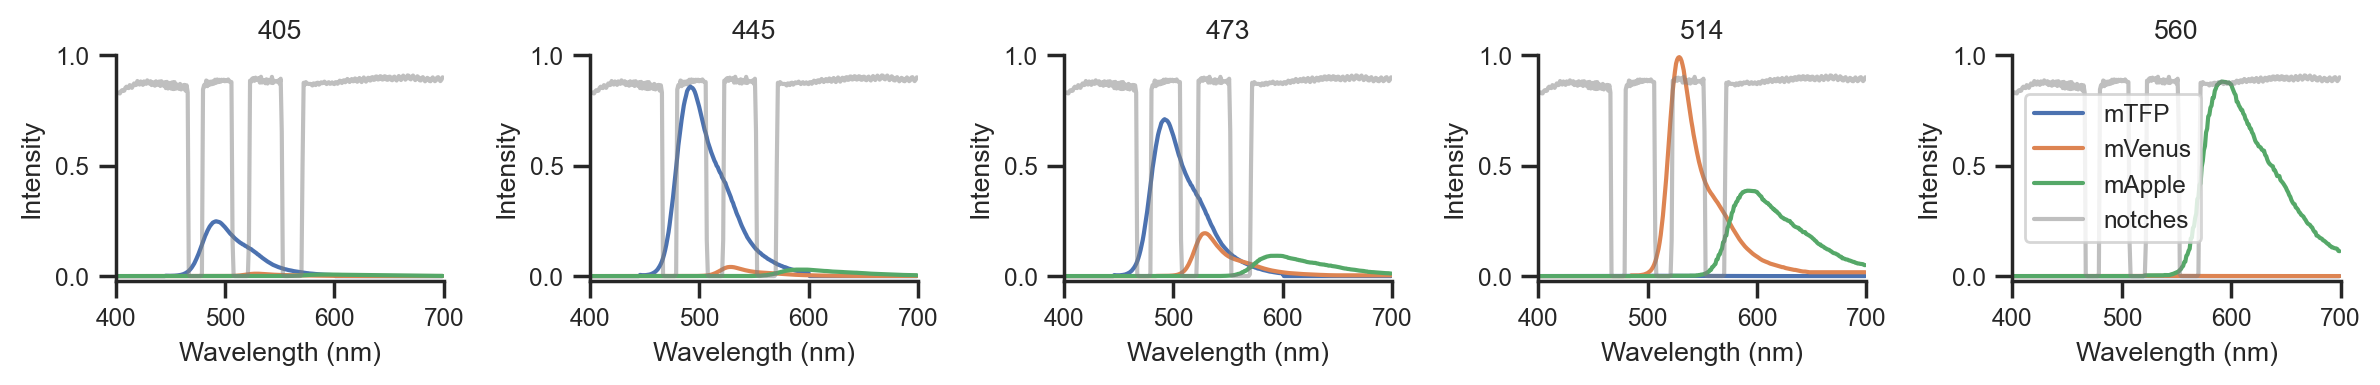

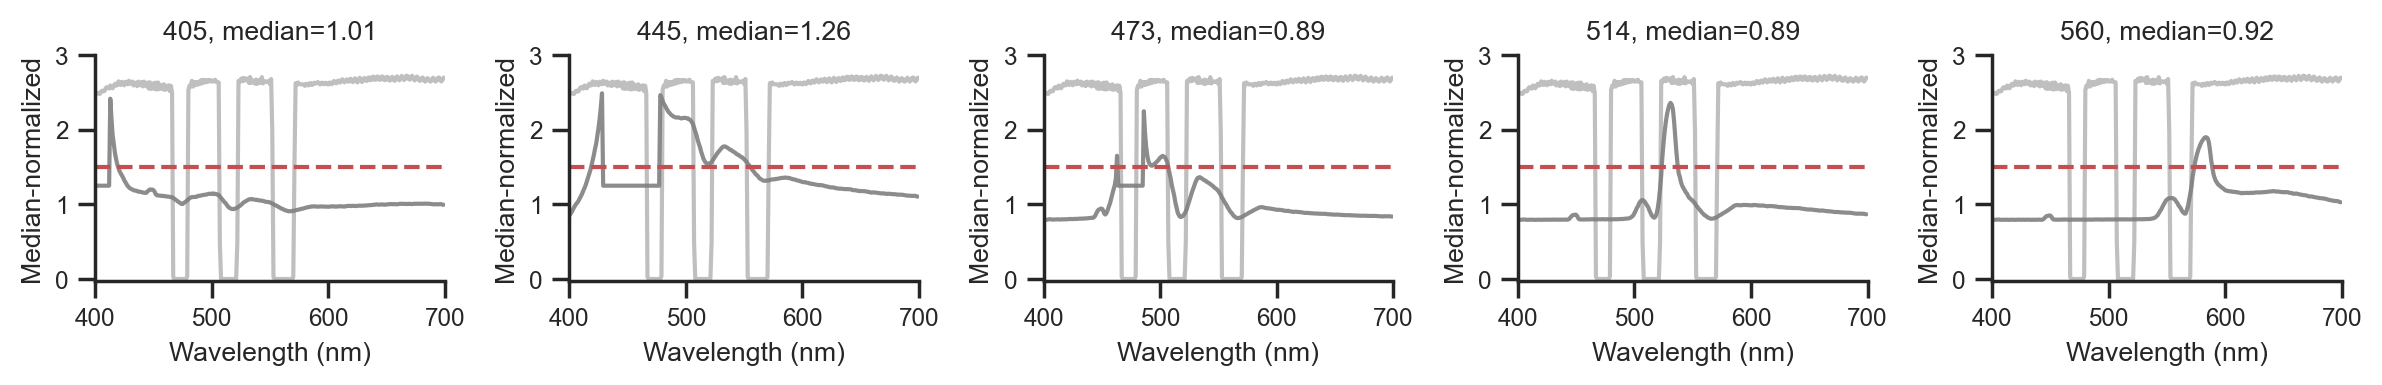

In [22]:
mean_X = F_detrend_normalized.mean("time")
tri_indicator_plots(mean_X, dat, laser)

- there is a large offset across all channels and wavelengths. 
- for each indicator are two populations (free and bound) that are fluorescing.
- according jGCaMP8f data (Ext. Data Fig 5), the emission spectrum of one of the free (blue solid line) is quite small compared to the bound (green solid line) population. 
- there is baseline signal recorded where the notches are present.
- we will subtract a single offset from the entire detrended and normalized data. 

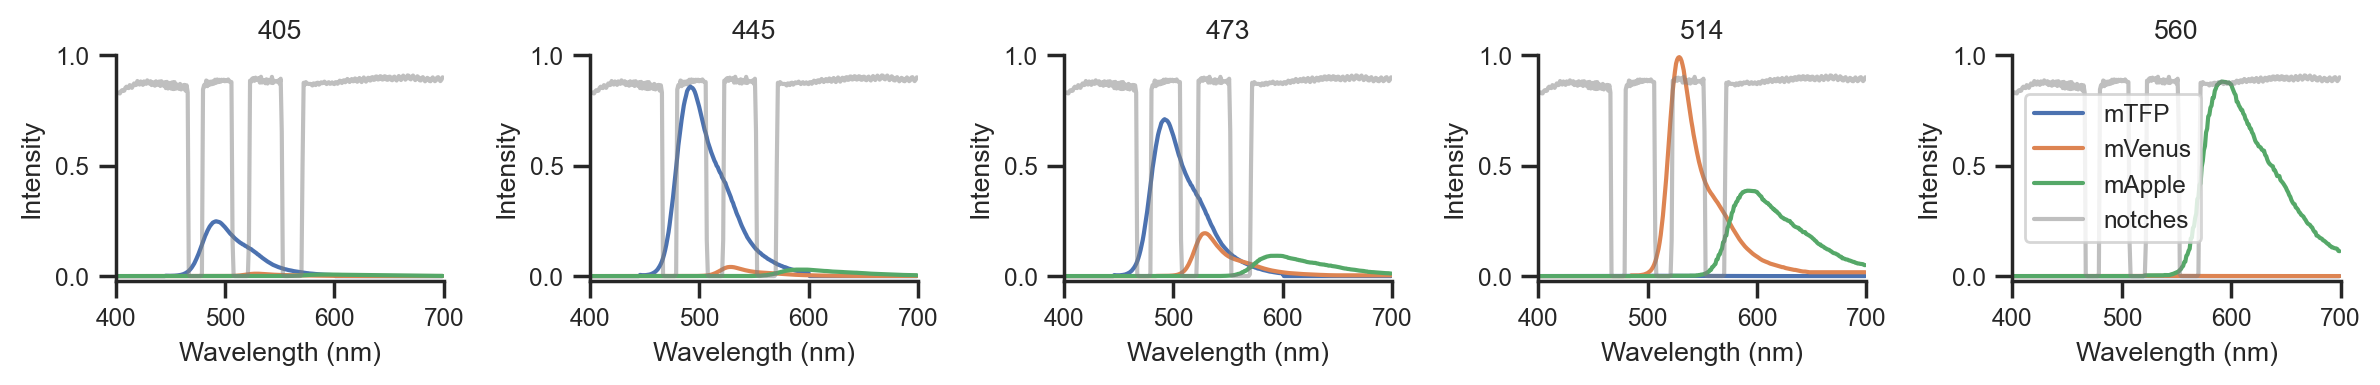

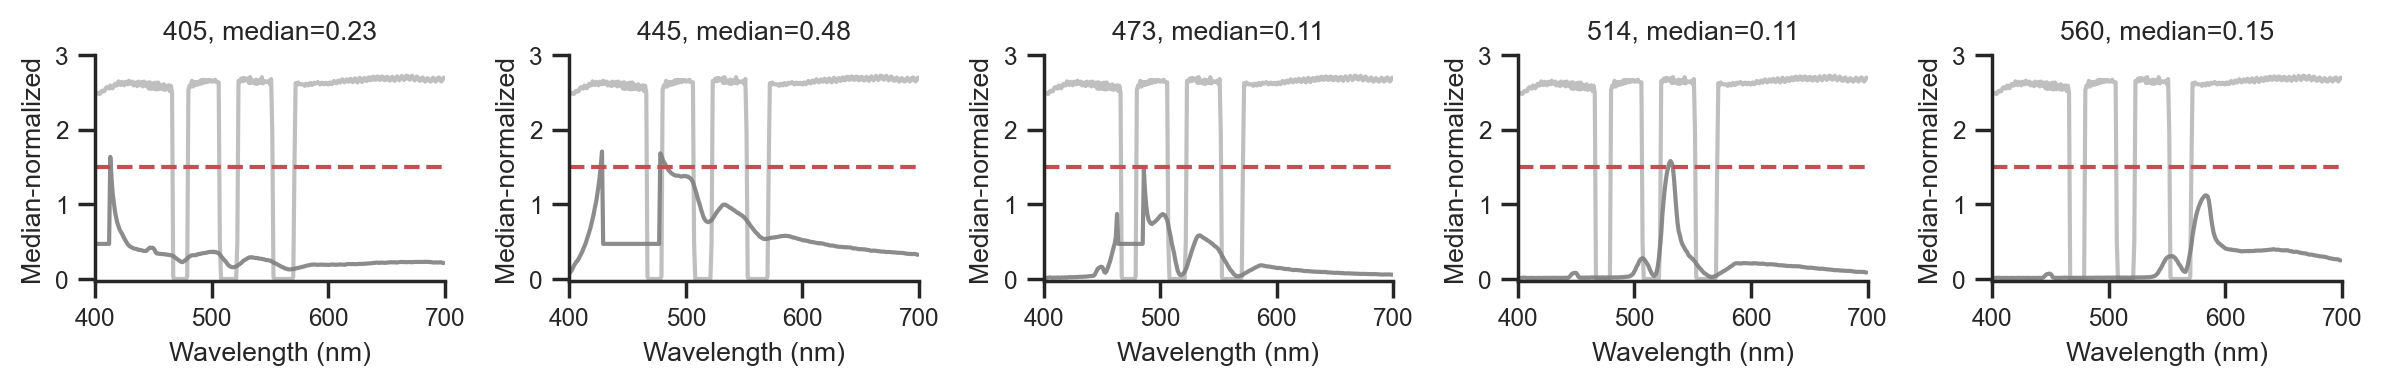

In [23]:
F_detrend_normalized_nobaseline = F_detrend_normalized - np.min(F_detrend_normalized.values)
mean_X = F_detrend_normalized_nobaseline.mean("time")
tri_indicator_plots(mean_X, dat, laser)

In [24]:
def concat_fn(xdat):
    n_samples = xdat.shape[0]
    n_channels = xdat.shape[1]
    n_wavelengths = xdat.shape[2]
    xdat_concat = np.concatenate([np.squeeze(xdat[:, j, :]) for j in range(n_channels)], axis=1)
    xdat_concat = xdat_concat.T
    assert xdat_concat.shape == (
        n_wavelengths * n_channels,
        n_samples,
    ), "shape mismatch"
    return xdat_concat


Y = concat_fn(F_detrend_normalized_nobaseline)
print(Y.shape)

(1500, 105400)


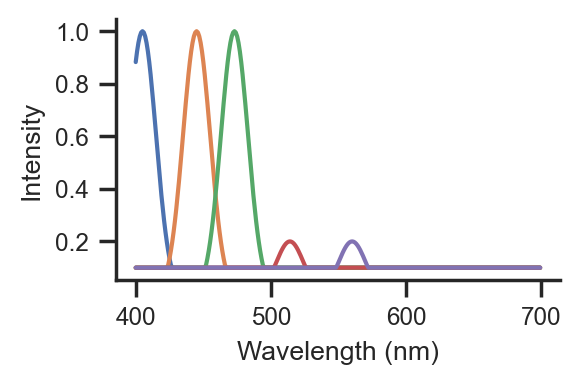

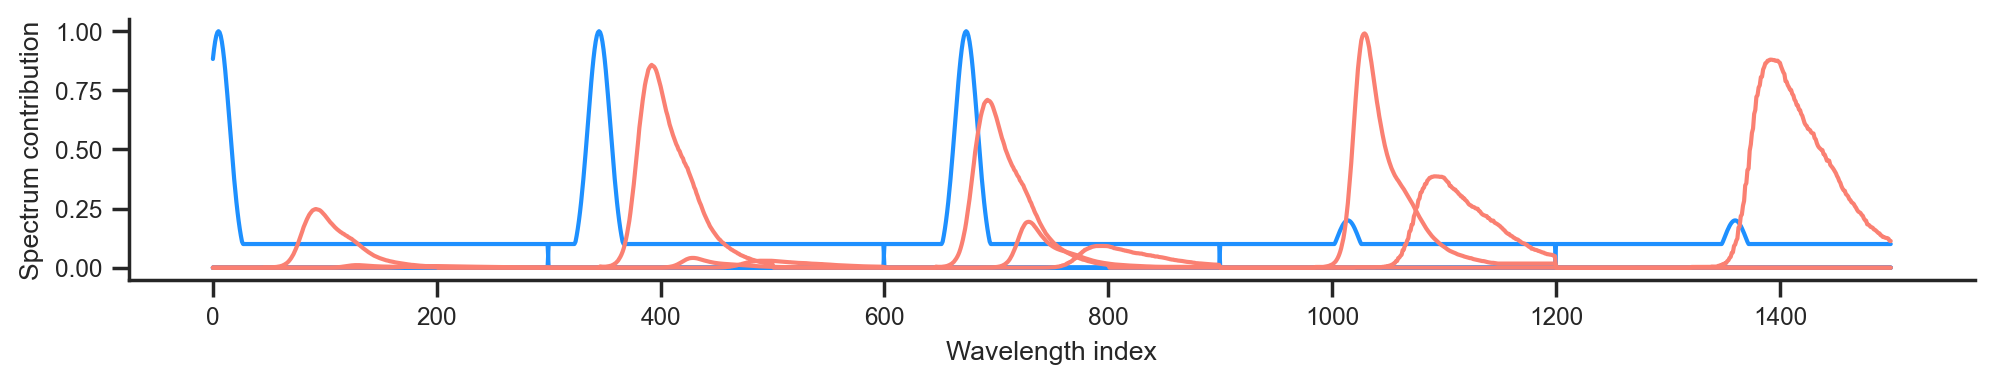

In [25]:
def make_laser_source(wavelengths, mean, sd, baseline, peak=1.0):
    gaussian = lambda x: np.exp(-((x - mean) ** 2) / (2 * sd**2))
    spectrum = gaussian(wavelengths)
    spectrum = (spectrum / np.max(spectrum)) * peak
    spectrum[spectrum < baseline] = baseline
    return spectrum


l_405 = make_laser_source(wavelengths=dat.L_arr, mean=405, sd=10, baseline=0.1)
l_445 = make_laser_source(wavelengths=dat.L_arr, mean=445, sd=10, baseline=0.1)
l_473 = make_laser_source(wavelengths=dat.L_arr, mean=473, sd=10, baseline=0.1)
l_514 = make_laser_source(wavelengths=dat.L_arr, mean=514, sd=10, baseline=0.1, peak=0.2)
l_560 = make_laser_source(wavelengths=dat.L_arr, mean=560, sd=10, baseline=0.1, peak=0.2)

w_405 = np.array([1, 0, 0, 0, 0])
w_445 = np.array([0, 1, 0, 0, 0])
w_473 = np.array([0, 0, 1, 0, 0])
w_514 = np.array([0, 0, 0, 1, 0])
w_560 = np.array([0, 0, 0, 0, 1])

f, ax = plt.subplots(1, 1, figsize=(3, 2))
ax.plot(dat.L_arr, l_405, label="405")
ax.plot(dat.L_arr, l_445, label="445")
ax.plot(dat.L_arr, l_473, label="473")
ax.plot(dat.L_arr, l_514, label="514")
ax.plot(dat.L_arr, l_560, label="560")
ax.set(xlabel="Wavelength (nm)", ylabel="Intensity")
plt.tight_layout()
plt.show()

n_lasers = 5
n_indicators = 3
n_sources = n_lasers + n_indicators  # lasers and indicators
n_channels = 5

A = np.empty((n_channels * n_wavelengths, n_sources))

# lasers
A[:, 0] = np.concatenate([l_405 * w_405[ch] for ch in range(n_channels)])
A[:, 1] = np.concatenate([l_445 * w_445[ch] for ch in range(n_channels)])
A[:, 2] = np.concatenate([l_473 * w_473[ch] for ch in range(n_channels)])
A[:, 3] = np.concatenate([l_514 * w_514[ch] for ch in range(n_channels)])
A[:, 4] = np.concatenate([l_560 * w_560[ch] for ch in range(n_channels)])

# indicators
A[:, 5] = np.concatenate([dat.S[0, :] * dat.W[0, ch] for ch in range(n_channels)])
A[:, 6] = np.concatenate([dat.S[1, :] * dat.W[1, ch] for ch in range(n_channels)])
A[:, 7] = np.concatenate([dat.S[2, :] * dat.W[2, ch] for ch in range(n_channels)])

colors = ["dodgerblue"] * n_lasers + ["salmon"] * n_indicators
f, ax = plt.subplots(1, 1, figsize=(10, 2))
for i in range(n_sources):
    ax.plot(A[:, i], label=f"{i}", c=colors[i])
ax.set(xlabel="Wavelength index", ylabel="Spectrum contribution")
plt.tight_layout()
plt.show()

Laser 405 --------------------


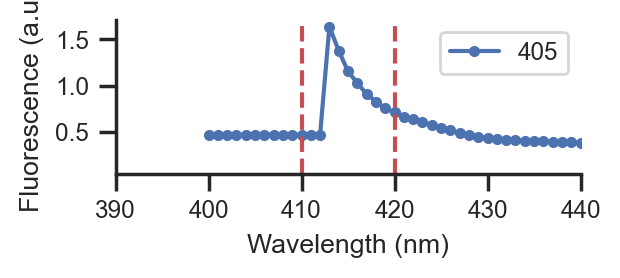

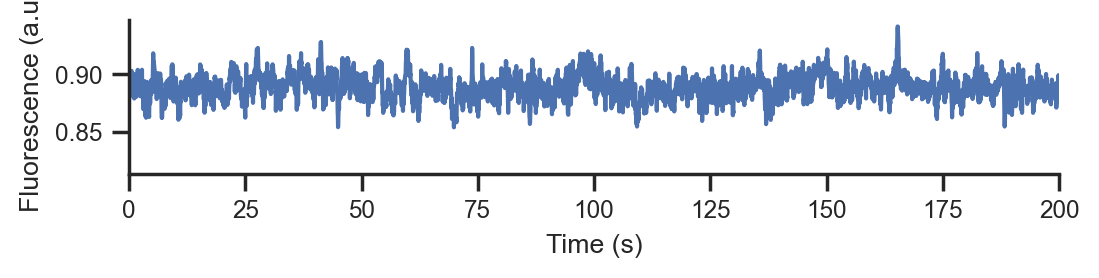

Laser 445 --------------------


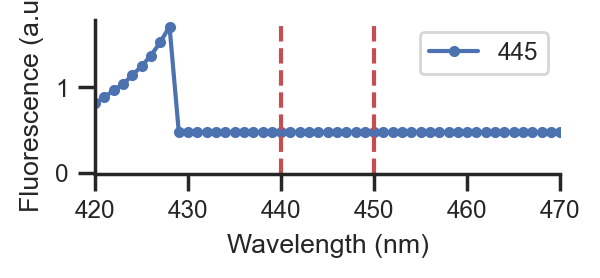

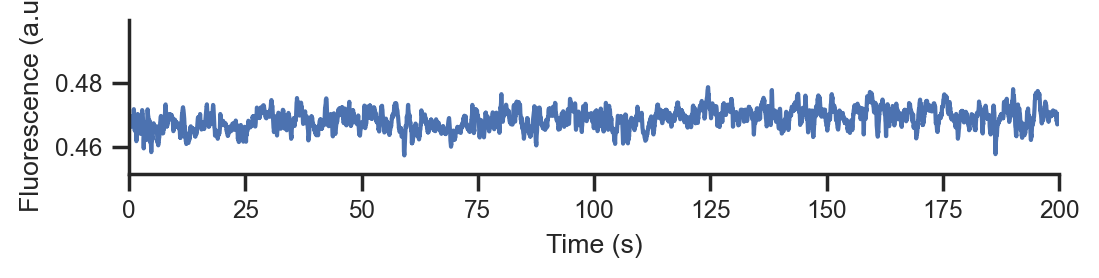

Laser 473 --------------------


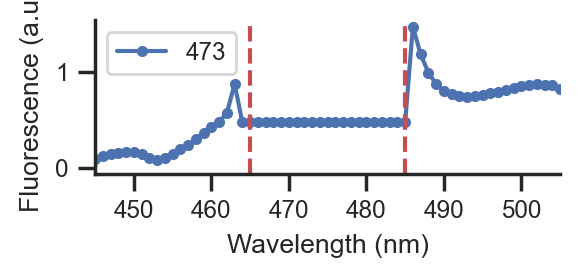

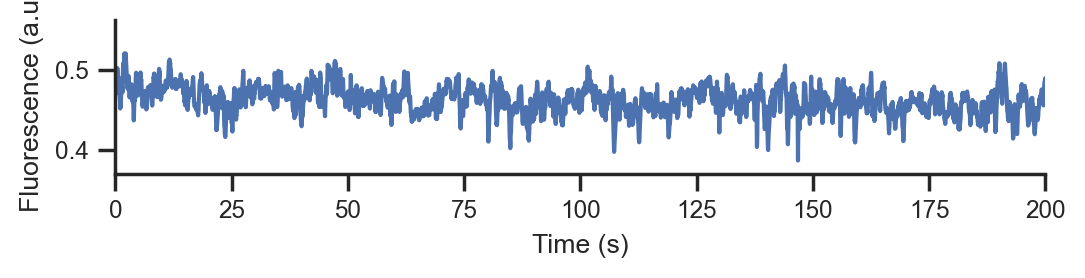

Laser 514 --------------------


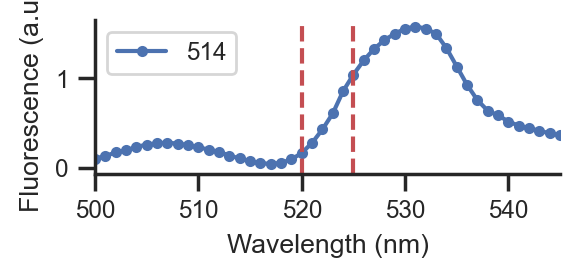

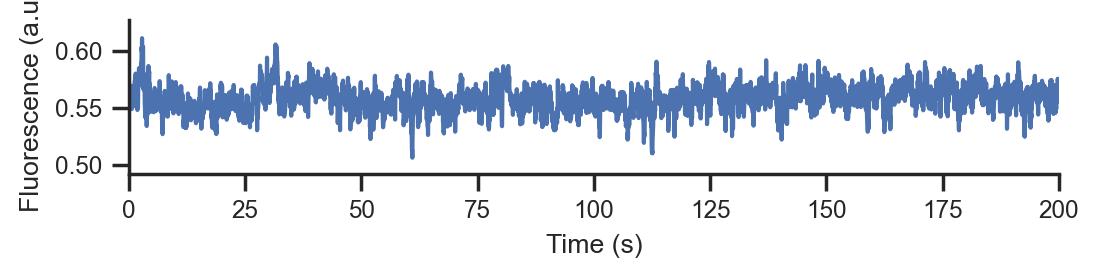

Laser 560 --------------------


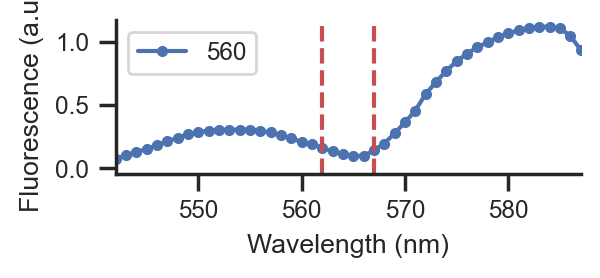

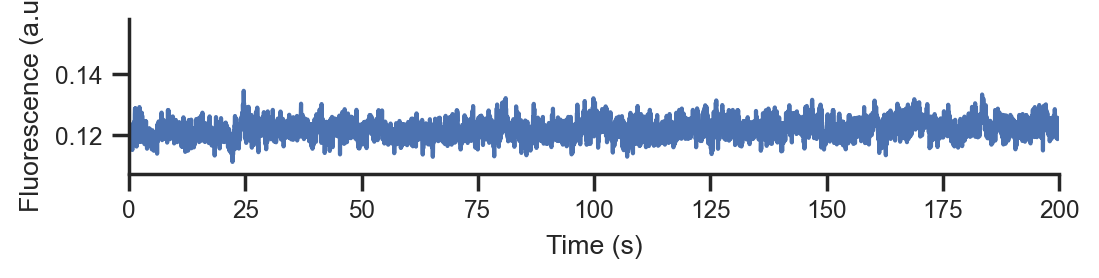

mFTP --------------------


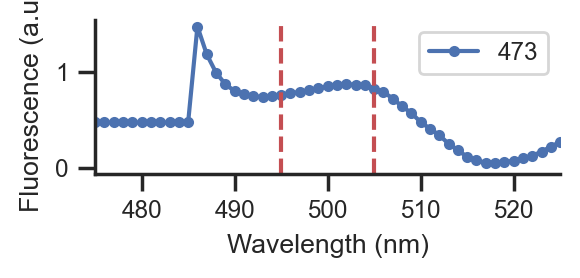

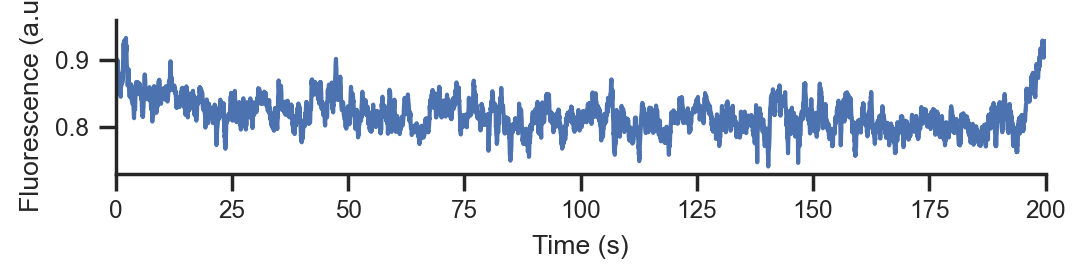

mVenus --------------------


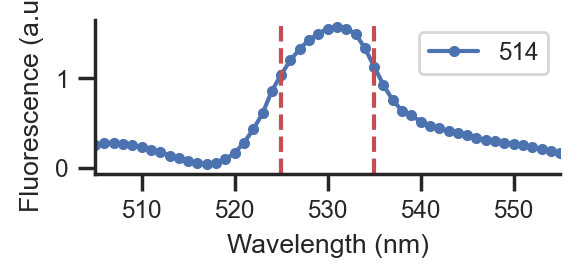

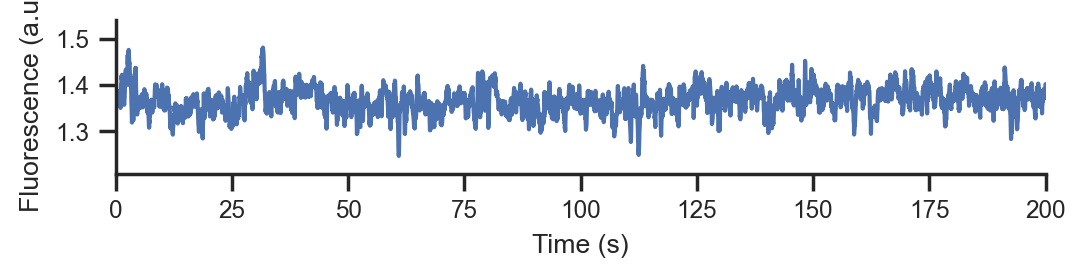

mApple --------------------


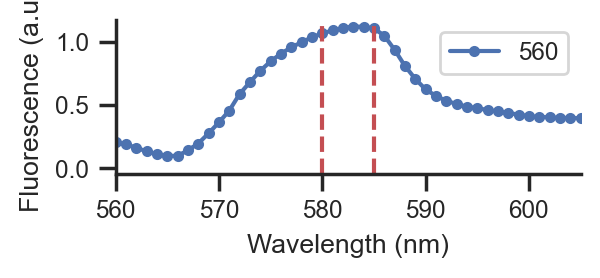

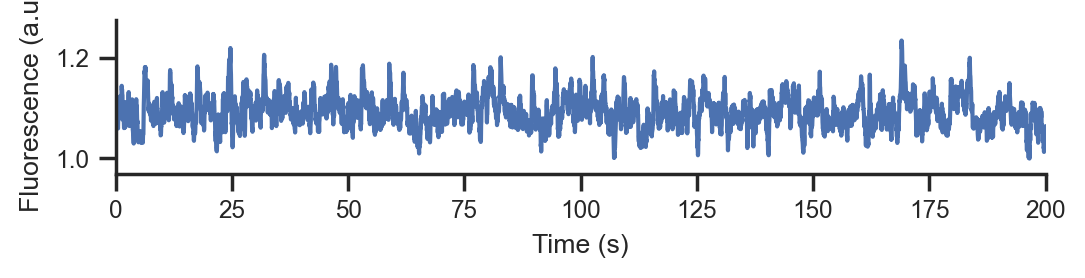

In [42]:
# Define the function to generate the plots
def plot_fluorescence(
    laser, wavelength, time_from_start, F_detrend_normalized_nobaseline, wavelength_range, time_range
):
    f, ax = plt.subplots(1, 1, figsize=(3, 1))
    ax.plot(wavelength, F_detrend_normalized_nobaseline.sel(laser=laser).mean("time"), ".-", label=f"{laser}")
    ax.axvline(wavelength_range[0], color="r", linestyle="--")
    ax.axvline(wavelength_range[1], color="r", linestyle="--")
    ax.set(
        xlabel="Wavelength (nm)",
        ylabel="Fluorescence (a.u.)",
        xlim=(wavelength_range[0] - 20, wavelength_range[1] + 20),
    )
    plt.legend()
    plt.show()

    f, ax = plt.subplots(1, 1, figsize=(6, 1))
    ax.plot(
        time_from_start,
        F_detrend_normalized_nobaseline.sel(laser=laser, wavelength=slice(*wavelength_range)).mean("wavelength"),
    )
    ax.set(xlabel="Time (s)", ylabel="Fluorescence (a.u.)", xlim=time_range)
    plt.show()


# Parameters for each laser
parameters = {
    "Laser 405": {"laser": 405, "wavelength_range": (410, 420), "time_range": (0, 200)},
    "Laser 445": {"laser": 445, "wavelength_range": (440, 450), "time_range": (0, 200)},
    "Laser 473": {"laser": 473, "wavelength_range": (465, 485), "time_range": (0, 200)},
    "Laser 514": {"laser": 514, "wavelength_range": (520, 525), "time_range": (0, 200)},
    "Laser 560": {"laser": 560, "wavelength_range": (562, 567), "time_range": (0, 200)},
    "mFTP": {"laser": 473, "wavelength_range": (495, 505), "time_range": (0, 200)},
    "mVenus": {"laser": 514, "wavelength_range": (525, 535), "time_range": (0, 200)},
    "mApple": {"laser": 560, "wavelength_range": (580, 585), "time_range": (0, 200)},
}

# Create a table of parameters
param_table = pd.DataFrame(parameters).T

# Generate plots for each laser
for laser, params in parameters.items():
    print(f"{laser} {'-'*20}")
    plot_fluorescence(
        params["laser"],
        wavelength,
        time_from_start,
        F_detrend_normalized_nobaseline,
        params["wavelength_range"],
        params["time_range"],
    )

In [27]:
display(param_table)

laser wavelength_range time_range
Laser 405   405       (410, 420)   (0, 200)
Laser 445   445       (440, 450)   (0, 200)
Laser 473   473       (465, 485)   (0, 200)
Laser 514   514       (520, 525)   (0, 200)
Laser 560   560       (562, 567)   (0, 200)
mFTP        473       (495, 505)   (0, 200)
mVenus      514       (525, 535)   (0, 200)
mApple      560       (580, 585)   (0, 200)

In [29]:
t_licks_rewarded = t_licks[reward == 1]
t_licks_unrewarded = t_licks[reward == 0]

### Initialization of parameters used for fitting

In [30]:
from sourcesep.utils.tri_indicator import get_dataset, source_params, get_source_1d, process_F

F, df_licks = get_dataset()
param_df = source_params()
F_proc = process_F(F)

display(param_df)

Paths are for dataset tagged: all
removing bleaching trend...


100%|██████████| 5/5 [00:35<00:00,  7.02s/it]


normalizing to median of time-averaged intensity...
setting above threshold signals to smaller value...


100%|██████████| 5/5 [00:02<00:00,  1.71it/s]


removing baseline...


source_idx     source laser wavelength_range
0           0  Laser 405   405       (410, 420)
1           1  Laser 445   445       (440, 450)
2           2  Laser 473   473       (465, 485)
3           3  Laser 514   514       (520, 525)
4           4  Laser 560   560       (562, 567)
5           5       mTFP   473       (495, 505)
6           6     mVenus   514       (525, 535)
7           7     mApple   560       (580, 585)

In [31]:
from sourcesep.models.nmf_tri_indicator import AHX

n_wavelengths = dat.L_arr.size
n_lasers = 5
n_indicators = 3
n_sources = n_lasers + n_indicators  # lasers and indicators
n_channels = 5
n_timepoints = 1000

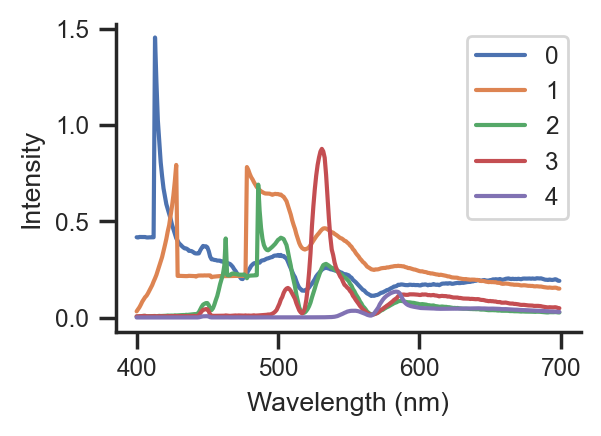

In [32]:
# subset of the data
F_proc_small = F_proc[:n_timepoints, :, :]

f_id_list = []
for source in param_df["source"]:
    f_1d = get_source_1d(F_proc_small, param_df, source=source)
    f_id_list.append(f_1d)
H_init_small = np.vstack(f_id_list)

# get inintialization for each laser from the approximate time series for that laser.
L = np.empty((F_proc_small.shape[1], F_proc_small.shape[2]))
for ch in range(F_proc_small.shape[1]):
    for lam in range(F_proc_small.shape[2]):
        L[ch, lam] = np.dot(H_init_small[ch, :], F_proc_small[:, ch, lam]) / n_timepoints

f, ax = plt.subplots(1, 1, figsize=(3, 2))
for i in range(L.shape[0]):
    ax.plot(dat.L_arr, L[i, :], label=f"{i}")
ax.set(xlabel="Wavelength (nm)", ylabel="Intensity")
plt.legend()
plt.show()

In [33]:
def keep_pos_diff(a, b, thr=1e-3):
    # set entries of b that are larger
    out = a - b
    out[out < thr] = thr
    return


Ld = L.copy()
# Ld[2, :] = keep_pos_diff(L[2, :], dat.S[0, :])
# Ld[3, :] = keep_pos_diff(L[3, :], dat.S[1, :])
# Ld[4, :] = keep_pos_diff(L[4, :], dat.S[2, :])

s = [Ld[0, :], Ld[1, :], Ld[2, :], Ld[3, :], Ld[4, :], dat.S[0, :], dat.S[1, :], dat.S[2, :]]
se = [w_405, w_445, w_473, w_514, w_560, dat.W[0, :], dat.W[1, :], dat.W[2, :]]

ahx = AHX(
    n_sources=n_sources,
    n_channels=n_channels,
    n_wavelengths=n_wavelengths,
    n_timepoints=n_timepoints,
    s=s,
    se=se,
    X=Y[:, :n_timepoints],
    H_init=H_init_small,
)

# only used for comparison of ahx with init
ahx_init = AHX(
    n_sources=n_sources,
    n_channels=n_channels,
    n_wavelengths=n_wavelengths,
    n_timepoints=n_timepoints,
    s=s,
    se=se,
    X=Y[:, :n_timepoints],
    H_init=H_init_small,
)

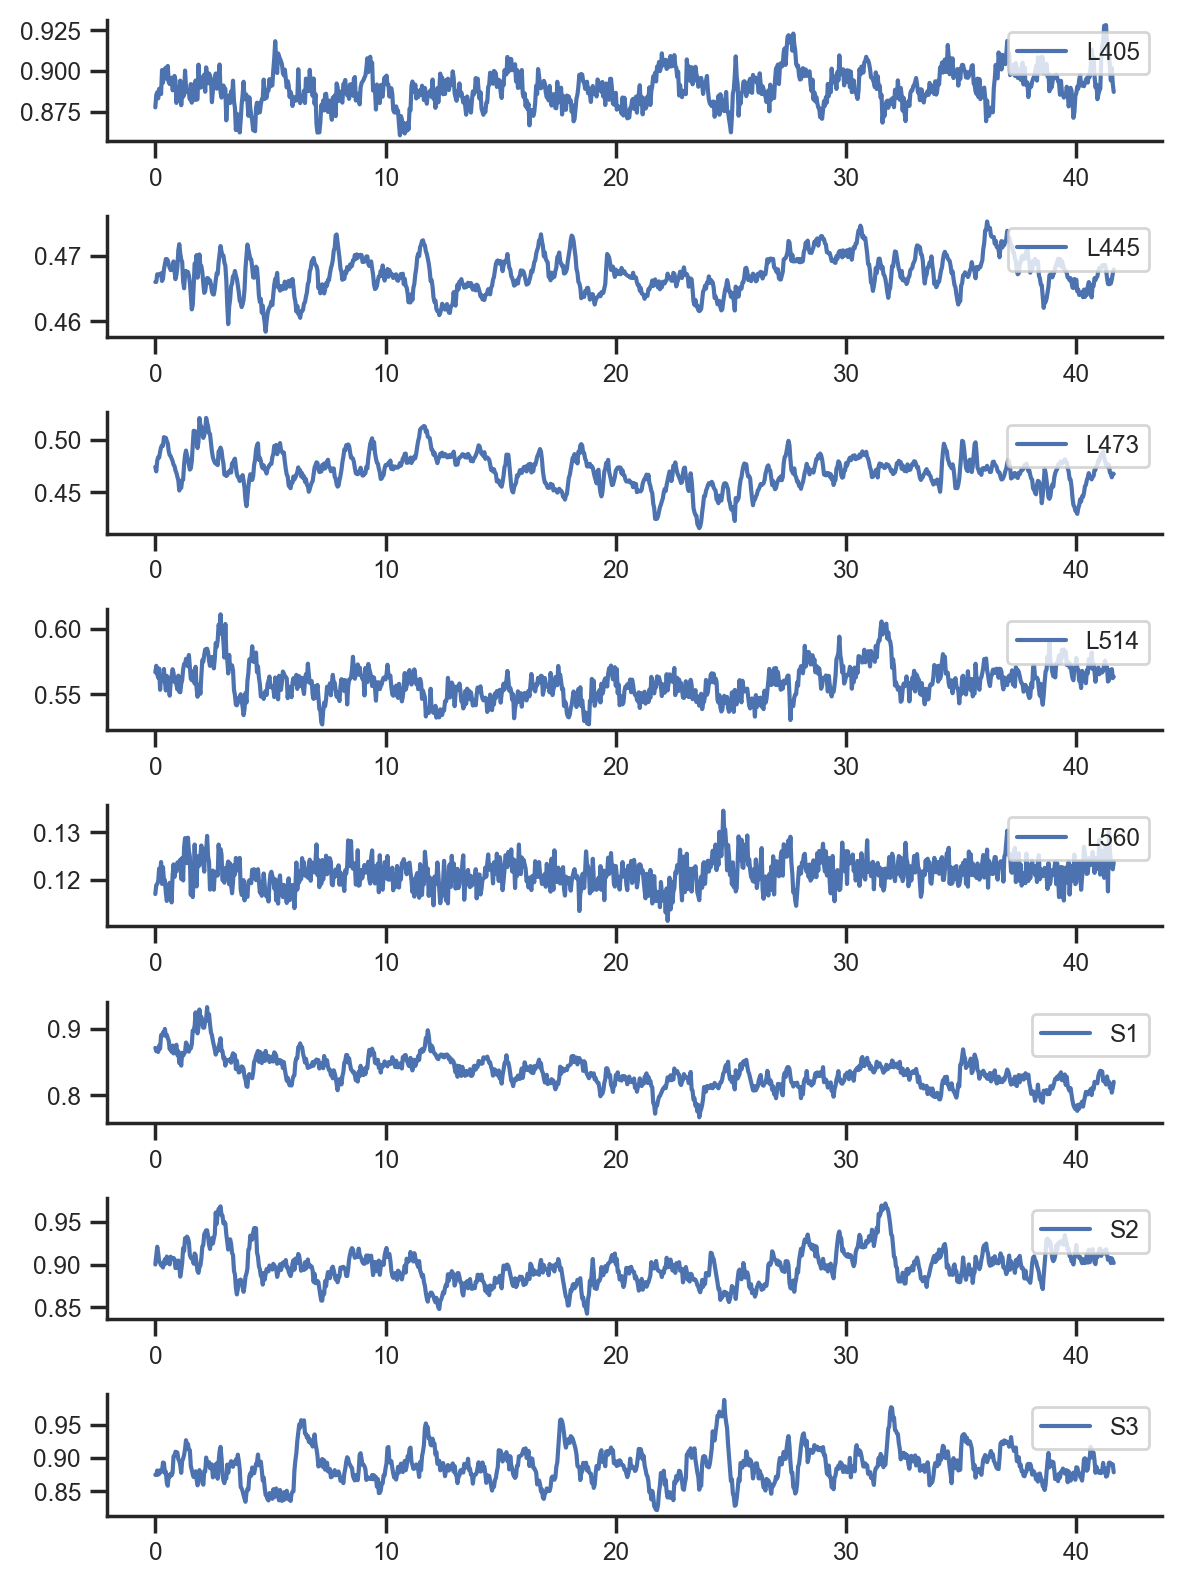

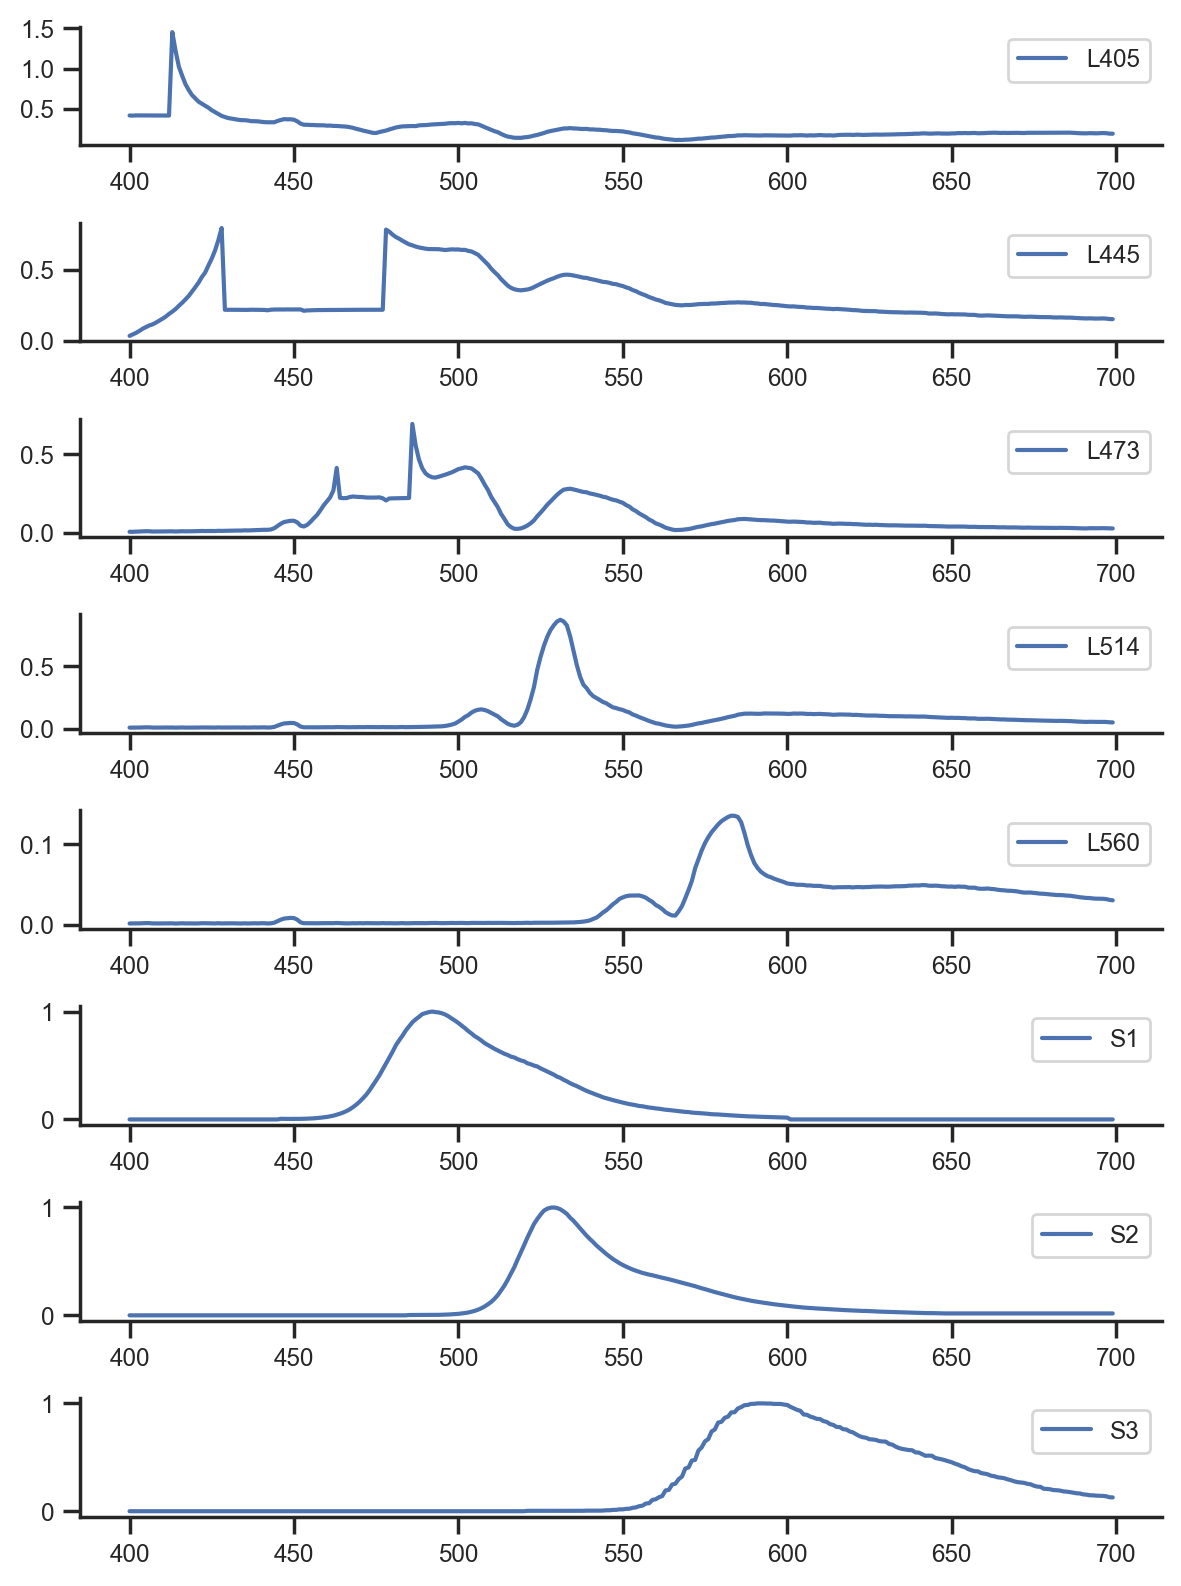

In [34]:
sources = ["L405", "L445", "L473", "L514", "L560", "S1", "S2", "S3"]
f, ax = plt.subplots(ahx.n_sources, 1, figsize=(6, ahx.n_sources))
for i in range(ahx.n_sources):
    time = (1 / f_sampling) * np.arange(ahx.n_timepoints)
    signal = ahx.h[str(i)].detach().numpy().ravel()
    ax[i].plot(time, signal, label=sources[i])
    ax[i].legend(loc="upper right")

plt.tight_layout()
plt.show()

f, ax = plt.subplots(ahx.n_sources, 1, figsize=(6, ahx.n_sources))
for i in range(ahx.n_sources):
    wavelengths = dat.L_arr
    signal1 = ahx.a[f"{i}"].detach().numpy().ravel()
    ax[i].plot(wavelength, signal1, label=sources[i])
    ax[i].legend(loc="upper right")

plt.tight_layout()
plt.show()

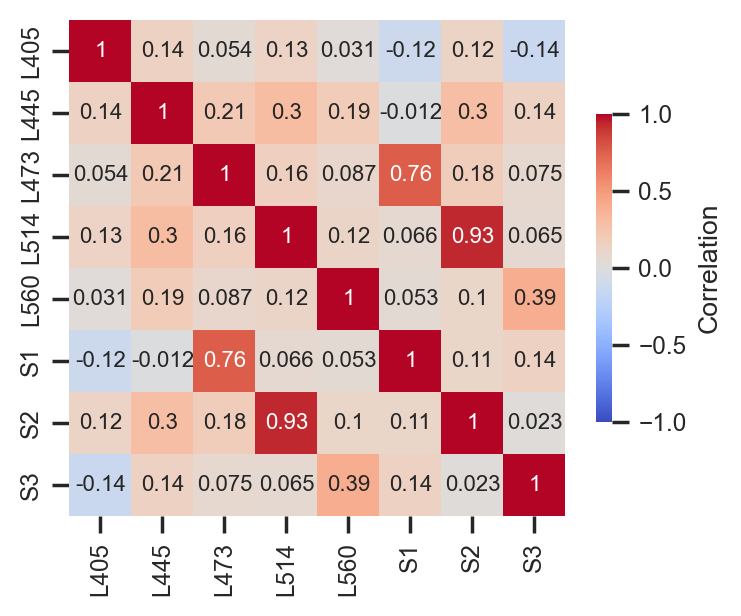

In [35]:
h = np.concatenate([ahx_init.h[str(i)].detach().numpy().reshape(1, -1) for i in range(ahx.n_sources)], axis=0)
c = np.corrcoef(h, rowvar=True)

f, ax = plt.subplots(1, 1, figsize=(4, 4))
sns.heatmap(
    c,
    cmap="coolwarm",
    square=True,
    annot=True,
    annot_kws={"size": 8},
    ax=ax,
    cbar_kws={"label": "Correlation", "shrink": 0.5},
    vmin=-1,
    vmax=1,
)
# set xlabels = sources
ax.set_xticklabels(sources, rotation=90)
ax.set_yticklabels(sources, rotation=90)
plt.show()

In [36]:
import torch

# learning rate schedule reduced over epochs.
ahx.fit(torch.tensor(Y[:, :n_timepoints]), n_steps=10_000, lr=1e-2)
ahx.fit(torch.tensor(Y[:, :n_timepoints]), n_steps=10_000, lr=1e-3)
ahx.fit(torch.tensor(Y[:, :n_timepoints]), n_steps=10_000, lr=1e-4)

Step: 0, Loss: 88197.80925036379
Step: 1000, Loss: 736.425441027157
Step: 2000, Loss: 128.8095751582669
Step: 3000, Loss: 126.0898509200515
Step: 4000, Loss: 124.33863402526275
Step: 5000, Loss: 122.80866011213139
Step: 6000, Loss: 121.29921426715204
Step: 7000, Loss: 119.71916892767676
Step: 8000, Loss: 117.73461984409457
Step: 9000, Loss: 115.50658579616879
Step: 10000, Loss: 113.37743261949073
Step: 0, Loss: 114.3850601915657
Step: 1000, Loss: 110.86530597482212
Step: 2000, Loss: 109.59630370296533
Step: 3000, Loss: 108.71140443351243
Step: 4000, Loss: 108.10438500038441
Step: 5000, Loss: 107.66793971461443
Step: 6000, Loss: 107.33227447555454
Step: 7000, Loss: 107.0531436965308
Step: 8000, Loss: 106.80992358645766
Step: 9000, Loss: 106.59507818038028
Step: 10000, Loss: 106.40324729413997
Step: 0, Loss: 106.40107977293802
Step: 1000, Loss: 106.21671138750526
Step: 2000, Loss: 106.05960883602754
Step: 3000, Loss: 105.91602560504941
Step: 4000, Loss: 105.78389159694748
Step: 5000, Los

In [37]:
def set_norm(signal):
    signal_norm = np.linalg.norm(signal)
    signal = (signal / signal_norm) * np.sqrt(signal.size)
    return signal

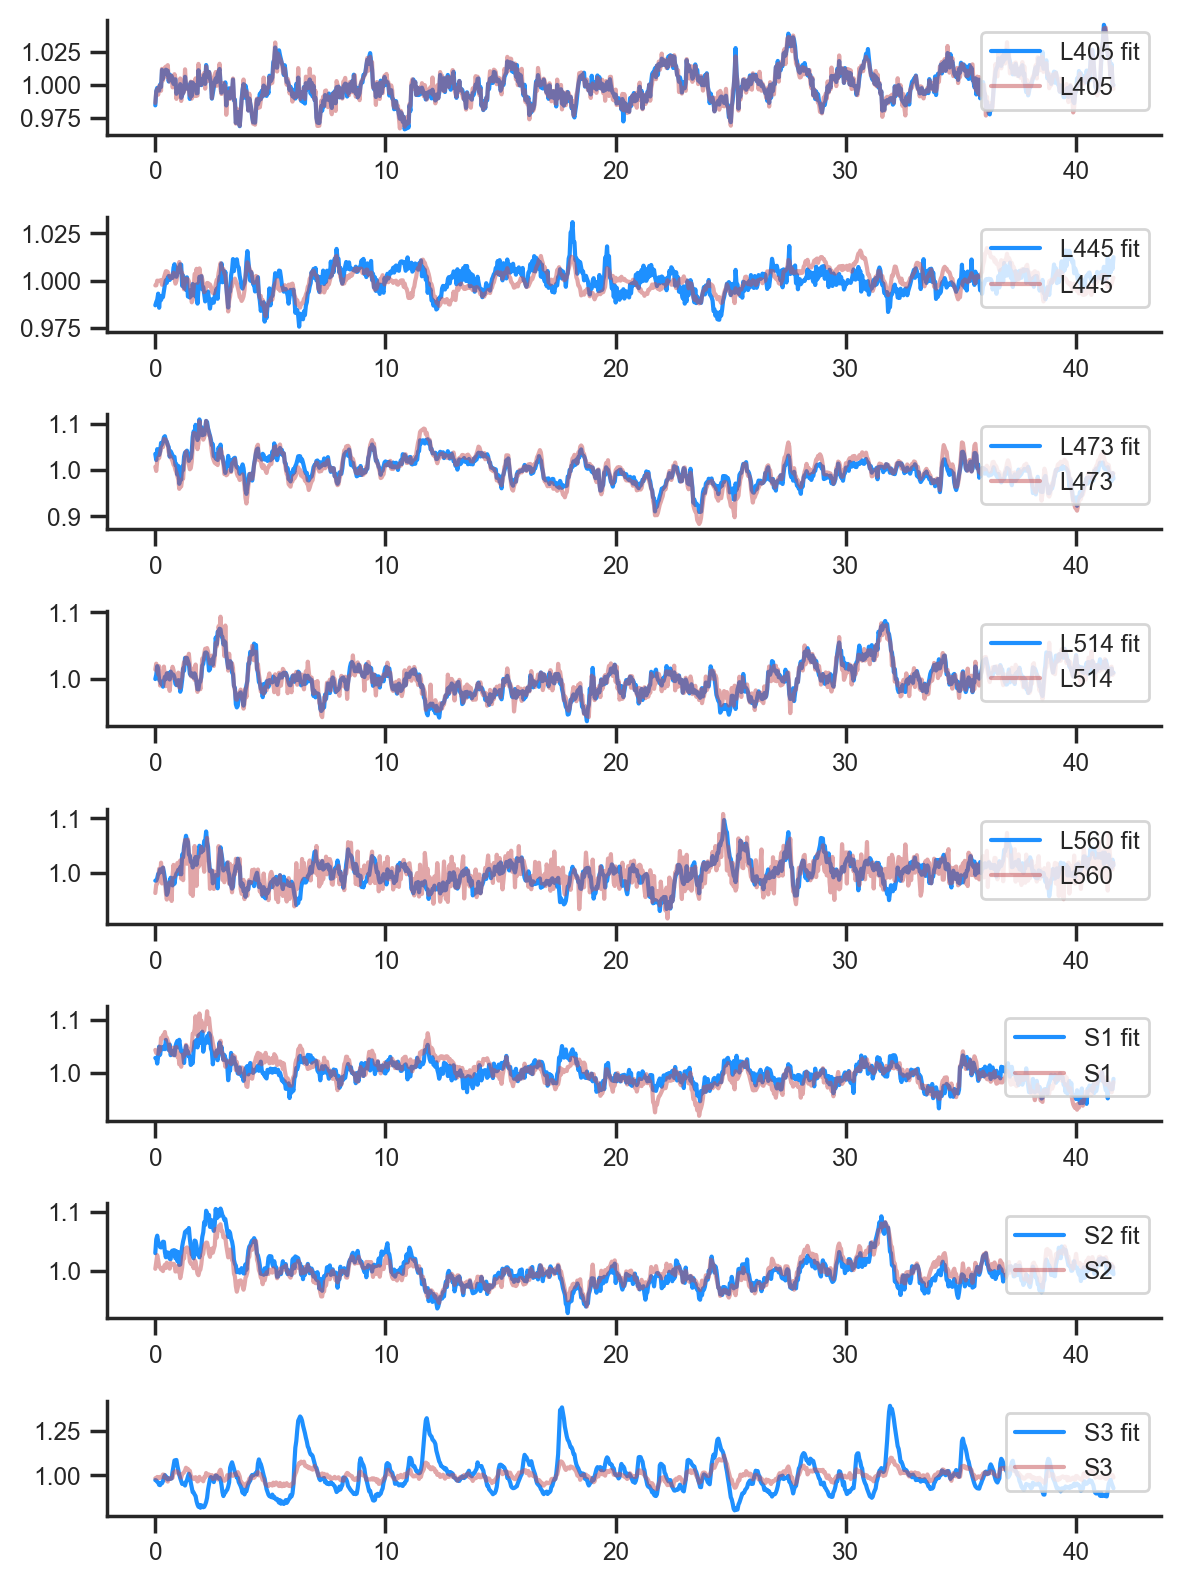

In [38]:
sources = ["L405", "L445", "L473", "L514", "L560", "S1", "S2", "S3"]
f, ax = plt.subplots(ahx.n_sources, 1, figsize=(6, ahx.n_sources))
for i in range(ahx.n_sources):
    time = (1 / f_sampling) * np.arange(ahx.n_timepoints)
    signal1 = ahx.h[str(i)].detach().numpy().ravel()
    signal2 = ahx_init.h[str(i)].detach().numpy().ravel()

    signal1 = set_norm(signal1)
    signal2 = set_norm(signal2)
    ax[i].plot(time, signal1, label=sources[i] + " fit", c="dodgerblue")
    ax[i].plot(time, signal2, label=sources[i], alpha=0.5, c="r")
    ax[i].legend(loc="upper right")

plt.tight_layout()
plt.show()

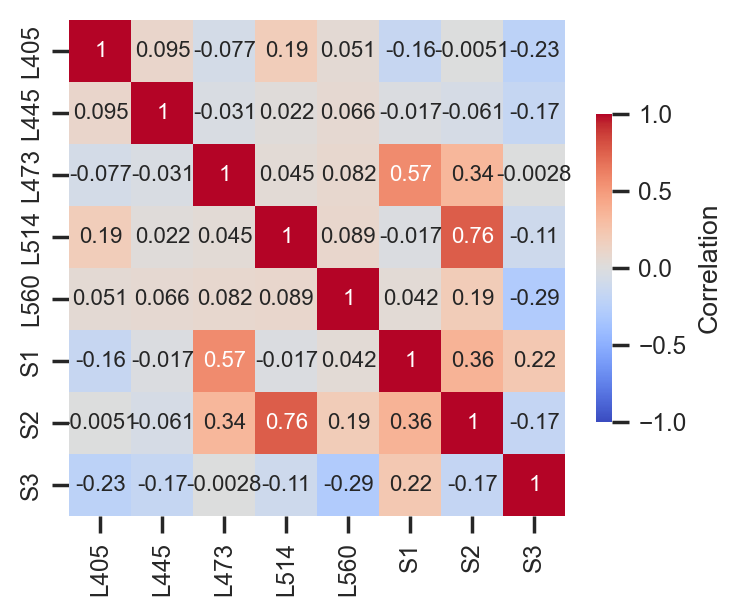

In [39]:
h = np.concatenate([ahx.h[str(i)].detach().numpy().reshape(1, -1) for i in range(ahx.n_sources)], axis=0)
c = np.corrcoef(h, rowvar=True)

f, ax = plt.subplots(1, 1, figsize=(4, 4))
sns.heatmap(
    c,
    cmap="coolwarm",
    square=True,
    annot=True,
    annot_kws={"size": 8},
    ax=ax,
    cbar_kws={"label": "Correlation", "shrink": 0.5},
    vmin=-1,
    vmax=1,
)
# set xlabels = sources
ax.set_xticklabels(sources, rotation=90)
ax.set_yticklabels(sources, rotation=90)
plt.show()

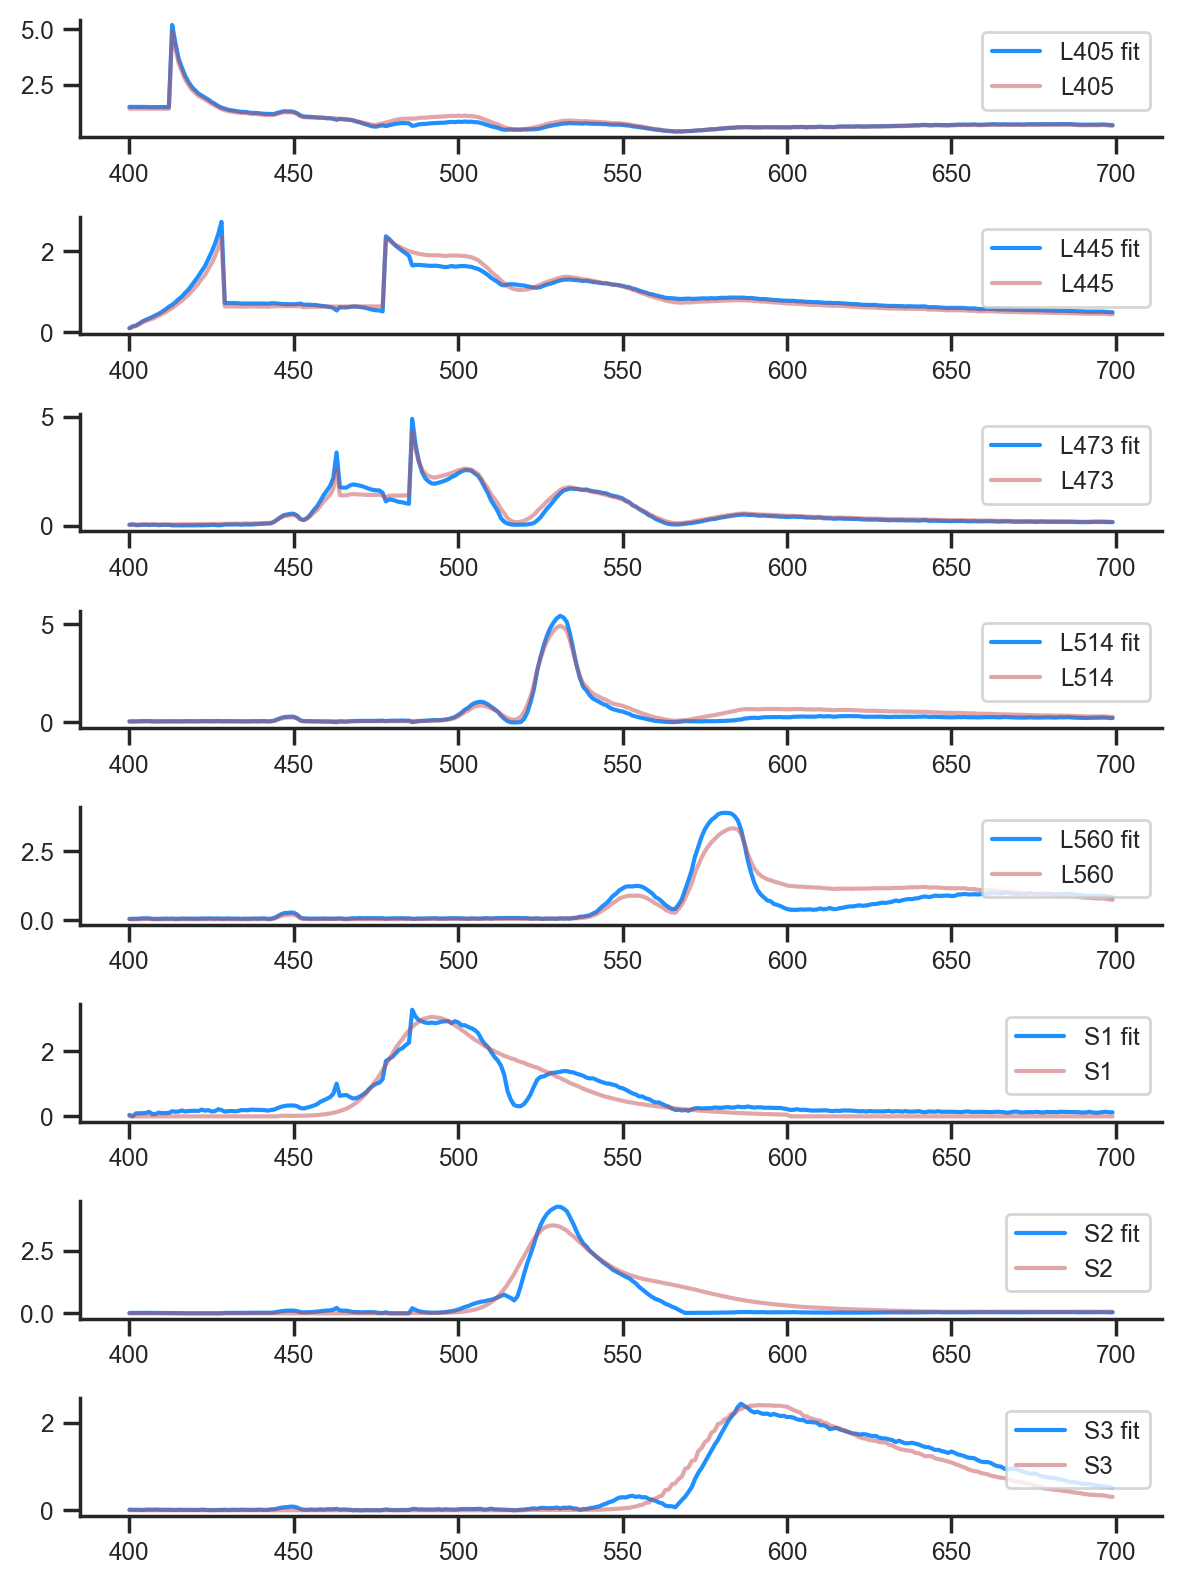

In [40]:
sources = ["L405", "L445", "L473", "L514", "L560", "S1", "S2", "S3"]
f, ax = plt.subplots(ahx.n_sources, 1, figsize=(6, ahx.n_sources))
for i in range(ahx.n_sources):
    wavelengths = dat.L_arr
    signal1 = ahx.a[f"{i}"].detach().numpy().ravel()
    signal2 = ahx_init.a[f"{i}"].detach().numpy().ravel()

    signal1 = set_norm(signal1)
    signal2 = set_norm(signal2)
    ax[i].plot(wavelength, signal1, c="dodgerblue", label=sources[i] + " fit")
    ax[i].plot(wavelength, signal2, label=sources[i], alpha=0.5, c="r")
    ax[i].legend(loc="upper right")

plt.tight_layout()
plt.show()

In [41]:
# Diagnostics:

# 1. L1 norms for lasers related to the individual sources?
# 2. Penalty on deviation from the original source spectra?
# 3. Smoothing schedule for the indicator spectra
# 4. Initialization removes indicator components from laser?
# 5. Transform the remaining time-series using fitted A.
# 6. Get no-animal with laser calibration data:
#    a. spectral analysis of the laser sources could inform smoothing constraints.
#    b. the empirical indicator spectrum could be estimated better.
# 7. Relative laser power may be important to consider.
